In [ ]:
pip install tensorflow==2.12

In [2]:
import tensorflow as tf
import tensorflow.compat.v2 as tf

from tensorflow import keras
from keras import backend
from keras.applications import imagenet_utils
from keras.engine import training
from keras.layers import VersionAwareLayers
from keras.utils import data_utils
from keras.utils import layer_utils
from tensorflow.python.util.tf_export import keras_export

In [ ]:
layers = VersionAwareLayers()

def vgg16(input_shape=None,
         classes=100,
         classifier_activation='softmax'):

    input_shape = imagenet_utils.obtain_input_shape(input_shape,
                                                   default_size=224,
                                                   min_size=32,
                                                   data_format=backend.image_data_format(),
                                                   require_flatten=True)
    print(input_shape)

    img_input = layers.Input(shape=input_shape)

    x = layers.Conv2D(64,
                     (3,3), activation='relu',
                     padding='same',
                     name='block1_conv1')(img_input)

    x = layers.Conv2D(64,
                     (3,3),activation='relu',
                     padding='same',
                     name='block1_conv2')(x)

    x = layers.MaxPooling2D((2,2), strides=(2,2),name='block1_pool')(x)

    x = layers.Conv2D(128,
                     (3,3),activation='relu',
                     padding='same',
                     name='block2_conv1')(x)

    x = layers.Conv2D(128,
                     (3,3), activation='relu',
                     padding='same',
                     name='block2_conv2')(x)

    x = layers.MaxPooling2D((2,2), strides=(2,2),name='block2_pool')(x)

    x = layers.Conv2D(256,
                     (3,3),activation='relu',
                     padding='same',
                     name='block3_conv1')(x)

    x = layers.Conv2D(256,
                     (3,3), activation='relu',
                     padding='same',
                     name='block3_conv2')(x)

    x = layers.Conv2D(256,
                      (3,3), activation='relu',
                     padding='same',
                     name='block3_conv3')(x)

    x = layers.MaxPooling2D((2,2), strides=(2,2),name='block3_pool')(x)

    x = layers.Conv2D(512,
                      (3,3),activation='relu',
                      padding='same',
                      name='block4_conv1')(x)

    x = layers.Conv2D(512,
                     (3,3), activation='relu',
                     padding='same',
                     name='block4_conv2')(x)

    x = layers.Conv2D(512,
                      (3,3), activation='relu',
                     padding='same',
                     name='block4_conv3')(x)

    x = layers.MaxPooling2D((2,2), strides=(2,2),name='block4_pool')(x)

    x = layers.Conv2D(512,
                      (3,3),activation='relu',
                      padding='same',
                      name='block5_conv1')(x)

    x = layers.Conv2D(512,
                     (3,3), activation='relu',
                     padding='same',
                     name='block5_conv2')(x)

    x = layers.Conv2D(512,
                      (3,3), activation='relu',
                     padding='same',
                     name='block5_conv3')(x)

    x = layers.MaxPooling2D((2,2), strides=(2,2),name='block5_pool')(x)

    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(4096, activation='relu', name='fc1')(x)
    x = layers.Dense(4096, activation='relu', name='fc2')(x)

    x = layers.Dense(classes, activation=classifier_activation,
                    name='predictions')(x)

    inputs = img_input

    model = training.Model(inputs, x, name='vgg16')

    return model



In [ ]:
vgg16 = vgg16()

vgg16.summary()

(224, 224, 3)
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128

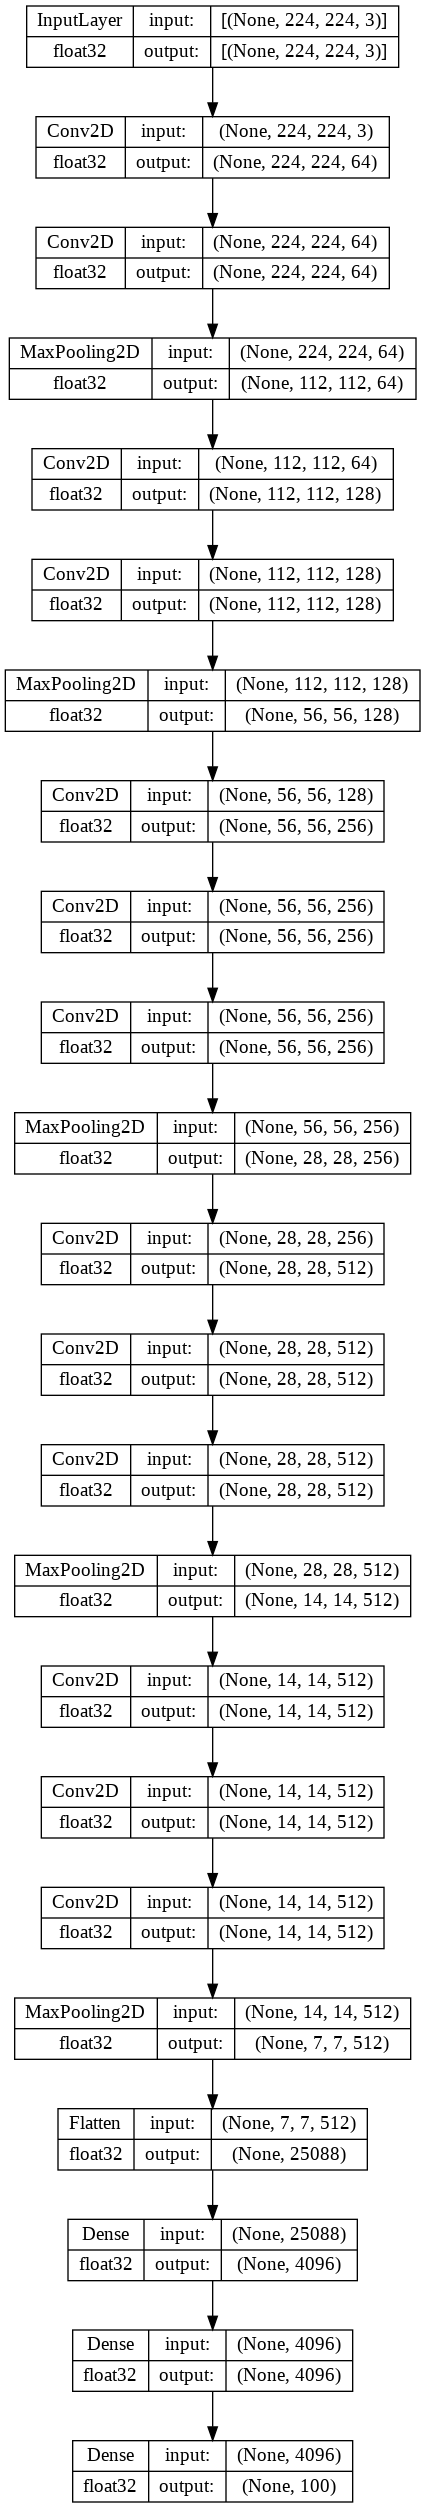

In [ ]:
tf.keras.utils.plot_model(vgg16, show_layer_names=False, show_shapes=True, show_dtype=True)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import datetime

In [ ]:
from keras.datasets import cifar100

In [ ]:
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

169001437/169001437 [==============================] - 5s 0us/step


In [ ]:
validation_images, validation_labels = train_images[:5000], train_labels[:5000]
train_images, train_labels = train_images[5000:], train_labels[5000:]

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

In [ ]:
def process_images(image, label):
    image = tf.image.per_image_standardization(image)

    image = tf.image.resize(image, (224, 224))

    return image, label

In [ ]:
import numpy as np
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()

test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()

validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()

print(train_ds_size, test_ds_size, validation_ds_size)

45000 10000 5000


In [ ]:
train_ds = (train_ds
           .map(process_images)
           .shuffle(buffer_size=train_ds_size/10)
           .batch(batch_size=1, drop_remainder=True))

test_ds = (test_ds
          .map(process_images)
          .shuffle(buffer_size=test_ds_size/10)
          .batch(batch_size=1, drop_remainder=True))

validation_ds = (validation_ds
                .map(process_images)
                .shuffle(buffer_size=validation_ds_size/10)
                .batch(batch_size=1, drop_remainder=True))

In [ ]:
vgg16.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
vgg16.fit(train_ds,
         validation_data=validation_ds,
         epochs=5,
         validation_freq=1)

Epoch 1/5
    7/45000 [..............................] - ETA: 32:27:20 - loss: 4.6068 - accuracy: 0.0000e+00

KeyboardInterrupt: ignored